In [1]:
import numpy as np
import torch as torch
import torch.nn as nn
from torchvision import transforms, utils
from torch.utils.data import DataLoader, Dataset, Subset
import matplotlib.pyplot as plt
from torchinfo import summary
from skimage import io
import os
import pandas as pd
from skimage import transform as tr
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import tqdm
from datetime import datetime
import pytz

2024-04-01 19:17:51.234266: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-01 19:17:51.234390: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-01 19:17:51.368952: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
#Creating arrays that store all the training and test data paths

#NOTE THAT THE DATA SHOULD BE UPLOADED ON KAGGLE AND ADDED AS INPUT (See FILE-> ADD INPUT)
#THESE ROOT PATHS SHOULD BE CHANGED ACCORDING TO YOUR KAGGLE SETUP!

#THESE ROOT PATHS SHOULD BE CHANGED ACCORDING TO YOUR SETUP!
root = "/kaggle/input/"
train_data_path = root + "Images/Images/train/Images/"
test_data_path = root + "Images/Images/test/Images/"
ground_truth_data_path = root + "GroundTruth/GroundTruth/train/GroundTruth_NSN/"
ground_truth_test = root + "GroundTruth/GroundTruth/test/GroundTruth_QCANet/"

train_data_paths = np.array([(train_data_path+filename) for filename in os.listdir(train_data_path) if 'Emb11' not in filename])
val_data_paths = np.array([(train_data_path+filename) for filename in os.listdir(train_data_path) if 'Emb11' in filename])
test_data_paths = np.array([test_data_path+i for i in os.listdir(test_data_path)])

In [3]:
#Custom Torch dataset class to create a dataset and pass it to Torch dataloaders
class EmbryoImageDataset(Dataset):
    def __init__(self, 
                 image_paths, 
                 ground_truth_dir, 
                 transform=None, 
                 flip_augmentation = [False, None],
                test_data = False):
        self.ground_truth_dir = ground_truth_dir
        self.image_paths = image_paths
        self.transform = transform
        self.flip_augmentation = flip_augmentation

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        
        image = io.imread(self.image_paths[index])
        filename = self.image_paths[index].split('/')[-1]
        ground_truth = io.imread(self.ground_truth_dir + filename)
        
        if self.transform is not None:
            image = self.transform(image)
            ground_truth = self.transform(ground_truth)
            
        if self.flip_augmentation[0]:
            #print("FLIPPING", self.flip_augmentation[0], self.flip_augmentation[1] )
            image = np.flip(image, axis = self.flip_augmentation[1])
            ground_truth = np.flip(ground_truth, axis = self.flip_augmentation[1])
            
        if test_data: 
            #Ground truth of test data was instance segmentation ground truth, therefore all values bigger than 0 should be set to 1
            ground_truth = ((ground_truth>0)*1).astype(ground_truth.dtype) 
    
        return torch.from_numpy(image.copy().astype('float32')), torch.from_numpy(ground_truth.copy().astype('float32'))
    

class NormalizeImage(object):
    
    def __init__(self):
        pass
    
    def __call__(self, image):
        
        img = (image-np.min(image))/(np.max(image)-np.min(image))
        
        return img
    
#Class that can perform a transform that interpolates the images along z, according to the resolution. 
# This class also makes sure that the object is of the desired size. In this case 128x128x128
class Resize_and_pad(object):
    
    def __init__(self, resolution = [0.8,0.8,1.75], desired_size = 128):
        
        self.resolution = resolution
        self.desired_size = desired_size
        
    def __call__(self, image):
        
        
        shape = np.shape(image)
        resize_factor = np.array(self.resolution)/0.8

        resized_image = tr.resize(image, 
                                  (shape[0]*resize_factor[2], 
                                   shape[1]*resize_factor[1], 
                                   shape[2]*resize_factor[0]),
                                     order=1)
        
        delta_shape = [128-value for value in resized_image.shape]
        max_pad_width = np.max(delta_shape)

        padded_image = np.pad(resized_image,[[0,max_pad_width],[0,max_pad_width],[0,max_pad_width]], mode = 'reflect')
        final_image = padded_image[:self.desired_size,:self.desired_size,:self.desired_size]
        
        return final_image
        

In [4]:
#Here the train and test dataset are created

#Composing transforms (normalization, resizing and padding)
composed = transforms.Compose([NormalizeImage(), Resize_and_pad(resolution= [0.8,0.8,1.75])])
#For the test set there was a different resolution so different transformation is needed
composed_test = composed = transforms.Compose([NormalizeImage(), Resize_and_pad(resolution= [0.8,0.8,2.0])])

#creating standard train dataset
train_data = EmbryoImageDataset(image_paths = train_data_paths,
                               ground_truth_dir = ground_truth_data_path,
                               transform = composed)

#creating the validation dataset for evaluating the model during training
val_data = EmbryoImageDataset(image_paths = val_data_paths,
                               ground_truth_dir = ground_truth_data_path,
                               transform = composed)

#Creating the test dataset for when the model is fully trained
test_data = EmbryoImageDataset(image_paths = test_data_paths,
                              ground_truth_dir= ground_truth_test,
                              test_data= True, transform = composed_test)

#Here data augmentation is performed by creating additional datasets that flip over the x-,y- and x&y-axis.
# This gives x4 the original datasize
train_data_flipx = EmbryoImageDataset(image_paths = train_data_paths,
                               ground_truth_dir = ground_truth_data_path,
                               transform = composed,
                                flip_augmentation= [True, 1])
train_data_flipy = EmbryoImageDataset(image_paths = train_data_paths,
                               ground_truth_dir = ground_truth_data_path,
                               transform = composed,
                                flip_augmentation= [True, 2])
train_data_flipxy = EmbryoImageDataset(image_paths = train_data_paths,
                               ground_truth_dir = ground_truth_data_path,
                               transform = composed,
                                flip_augmentation= [True, (0,1)])

#Here all the train datasets are combined to form the augmented dataset with x4 data size
augmented_train_data = torch.utils.data.ConcatDataset([train_data,train_data_flipx,train_data_flipy,train_data_flipxy])

batch_size = 1
#Creating the dataloaders based on the created datasets
train_loader = DataLoader(augmented_train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size,shuffle=True)

#Printing the amount of training/test images in both datasets
print(len(augmented_train_data))
print(len(val_data))
print(len(test_data))

440
11
44


In [5]:
"""
#Creating small training and test set for testing purposes
train_data_small = Subset(train_data, [i for i in range(0,10)])
val_data_small = Subset(val_data, [i for i in range(0,2)])

train_loader_small = DataLoader(train_data_small, batch_size=1, shuffle=True)
val_loader_small = DataLoader(val_data_small, batch_size=1,shuffle=True)

print(len(train_data_small), len(val_data_small))
"""

'\n#Creating small training and test set for testing purposes\ntrain_data_small = Subset(train_data, [i for i in range(0,10)])\nval_data_small = Subset(val_data, [i for i in range(0,2)])\n\ntrain_loader_small = DataLoader(train_data_small, batch_size=1, shuffle=True)\nval_loader_small = DataLoader(val_data_small, batch_size=1,shuffle=True)\n\nprint(len(train_data_small), len(val_data_small))\n'

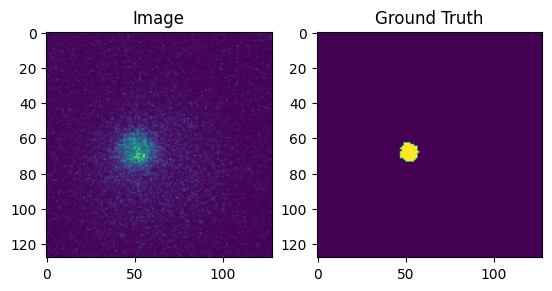

torch.Size([128, 128, 128]) torch.Size([128, 128, 128])
torch.float32 torch.float32


In [6]:
#Visualizing a random training sample from the training dataset

N = 64
fig, ax = plt.subplots(1, 2)

index = int(np.random.rand()*len(augmented_train_data))

image, truth = augmented_train_data[index]

ax[0].imshow(image[N])
ax[0].set_title("Image")
ax[1].imshow(truth[N])
ax[1].set_title("Ground Truth")
plt.show()

print(image.shape, truth.shape)
print(image.dtype, truth.dtype)

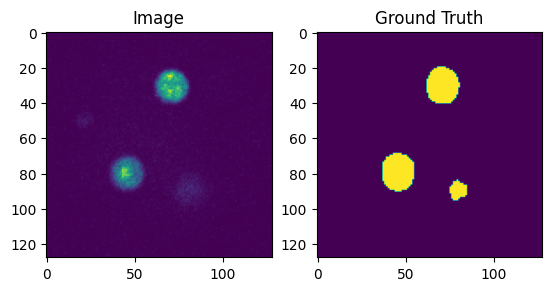

torch.Size([128, 128, 128]) torch.Size([128, 128, 128])


In [7]:
#Visualizing a random test sample of the validation dataset

N = 64
fig, ax = plt.subplots(1, 2)

index = int(np.random.rand()*len(val_data))

image, truth = val_data[index]

ax[0].imshow(image[N])
ax[0].set_title("Image")
ax[1].imshow(truth[N])
ax[1].set_title("Ground Truth")
plt.show()

print(image.shape, truth.shape)

In [8]:
#Our own very straightforward, albeit not super nice, implementation of the U-net 3D architecture by the paper: '3D U-Net: Learning Dense Volumetric Segmentation from Sparse Annotation'
class UNet3D(nn.Module):
    
    def __init__(self, in_channels = 1, out_channels = 1):
        super(UNet3D, self).__init__()
        
        #Activation functions and maxpooling
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim = 1)
        self.maxpool = nn.MaxPool3d(kernel_size=(2,2,2), stride=2)
        
        #Encoder Block 1
        self.conv1 = nn.Conv3d(in_channels = in_channels, out_channels = 32, kernel_size = (3,3,3), padding = 1)
        self.bn1 = nn.BatchNorm3d(32)
        self.conv2 = nn.Conv3d(in_channels = 32, out_channels = 64, kernel_size = (3,3,3), padding = 1)
        self.bn2 = nn.BatchNorm3d(64)
        
        #Encoder Block 2
        self.conv3 = nn.Conv3d(in_channels = 64, out_channels = 64, kernel_size = (3,3,3), padding = 1)
        self.bn3 = nn.BatchNorm3d(64)
        self.conv4 = nn.Conv3d(in_channels = 64, out_channels = 128, kernel_size = (3,3,3), padding = 1)
        self.bn4 = nn.BatchNorm3d(128)
        
        #Encoder Block 3
        self.conv5 = nn.Conv3d(in_channels = 128, out_channels = 128, kernel_size = (3,3,3), padding = 1)
        self.bn5 = nn.BatchNorm3d(128)
        self.conv6 = nn.Conv3d(in_channels = 128, out_channels = 256, kernel_size = (3,3,3), padding = 1)
        self.bn6 = nn.BatchNorm3d(256)
        
        #Bottleneck block
        self.conv7 = nn.Conv3d(in_channels = 256, out_channels = 256, kernel_size = (3,3,3), padding = 1)
        self.bn7 = nn.BatchNorm3d(256)
        self.conv8 = nn.Conv3d(in_channels = 256, out_channels = 512, kernel_size = (3,3,3), padding = 1)
        self.bn8 = nn.BatchNorm3d(512)
        
        #Decoder Block 1
        self.upconv1 = nn.ConvTranspose3d(in_channels = 512, out_channels = 512, kernel_size = (2,2,2), stride = 2)
        self.conv9 = nn.Conv3d(in_channels = 512+256, out_channels = 256, kernel_size = (3,3,3), padding = 1)
        self.bn9 = nn.BatchNorm3d(256)
        self.conv10 = nn.Conv3d(in_channels = 256, out_channels = 256, kernel_size = (3,3,3), padding = 1)
        self.bn10 = nn.BatchNorm3d(256)
        
        #Decoder Block 2
        self.upconv2 = nn.ConvTranspose3d(in_channels = 256, out_channels = 256, kernel_size = (2,2,2), stride = 2)
        self.conv11 = nn.Conv3d(in_channels = 256+128, out_channels = 128, kernel_size = (3,3,3), padding = 1)
        self.bn11 = nn.BatchNorm3d(128)
        self.conv12 = nn.Conv3d(in_channels = 128, out_channels = 128, kernel_size = (3,3,3), padding = 1)
        self.bn12 = nn.BatchNorm3d(128)
        
        #Decoder Block 3 
        self.upconv3 = nn.ConvTranspose3d(in_channels = 128, out_channels = 128, kernel_size = (2,2,2), stride = 2)
        self.conv13 = nn.Conv3d(in_channels = 128+64, out_channels = 64, kernel_size = (3,3,3), padding = 1)
        self.bn13 = nn.BatchNorm3d(64)
        self.conv14 = nn.Conv3d(in_channels = 64, out_channels = 64, kernel_size = (3,3,3), padding = 1)
        self.bn14 = nn.BatchNorm3d(64)
        
        #Final convolution
        self.conv15 = nn.Conv3d(in_channels = 64, out_channels = out_channels, kernel_size = (1,1,1))
        
    def forward(self, input):

        #Encoder Block 1
        out = self.relu(self.bn1(self.conv1(input)))
        out = self.relu(self.bn2(self.conv2(out)))
        skip_connection1 = out
        out = self.maxpool(out)

        #Encoder Block 2
        out = self.relu(self.bn3(self.conv3(out)))
        out = self.relu(self.bn4(self.conv4(out)))
        skip_connection2 = out
        out = self.maxpool(out)

        #Encoder Block 3
        out = self.relu(self.bn5(self.conv5(out)))
        out = self.relu(self.bn6(self.conv6(out)))
        skip_connection3 = out
        out = self.maxpool(out)

        #Bottleneck layer
        out = self.relu(self.bn7(self.conv7(out)))
        out = self.relu(self.bn8(self.conv8(out)))

        #Decoder Block 1
        out = self.upconv1(out)
        out = torch.cat(tensors = (out, skip_connection3), dim = 1)
        out = self.relu(self.bn9(self.conv9(out)))
        out = self.relu(self.bn10(self.conv10(out)))

        #Decoder Block 2
        out = self.upconv2(out)
        out = torch.cat(tensors = (out, skip_connection2), dim = 1)
        out = self.relu(self.bn11(self.conv11(out)))
        out = self.relu(self.bn12(self.conv12(out)))

        #Decoder Block 3
        out = self.upconv3(out)
        out = torch.cat(tensors = (out, skip_connection1), dim = 1)
        out = self.relu(self.bn13(self.conv13(out)))
        out = self.relu(self.bn14(self.conv14(out)))

        #Final convolution + sigmoid activation
        out = self.conv15(out)
        out = self.softmax(out)

        return out

In [9]:
#Specifying the device, testing whether there is a GPU available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Current device: {device}')

#Creating an instance of the network and moving it to the created device
net = UNet3D(in_channels= 1, out_channels = 2).to(device)

#Set optimizer to Adam
lr = 0.0001
optimizer = optim.Adam(net.parameters(), lr = lr)

Current device: cuda


In [10]:
#Function to return the IoU validation score of the best performing network:
def highest_IoU(bestnetwork_file_path, device):
    highest_score = 0
    if os.path.isfile(checkpoint_file_path):
        print("Best network file found")
        if device.type == "cpu":
            file = torch.load(bestnetwork_file_path, torch.device('cpu'))
            highest_score = file['loss_acc']['Validation accuracy'][-1].item()
        else:
            file = torch.load(bestnetwork_file_path, torch.device('cuda'))
            highest_score = file['loss_acc']['Validation accuracy'][-1].item()
        print(f"Using highest accuracy score of {highest_score}")
    else:
        print("No previous score found, using default value of 0")
    
    return highest_score
    
    
#If checkpoint file exists, load the file and set model and optimizer parameters
def loadprev_training(checkpoint_file_path, device, network, optimizer):

    start_epoch = 0
    checkpoint_file = None
    
    train_loss_array = []
    train_acc_array = []
    val_loss_array = []
    val_acc_array = []

    if os.path.isfile(checkpoint_file_path):
        print("Checkpoint file found")
        if device.type == "cpu":
            
            checkpoint_file = torch.load(checkpoint_file_path, torch.device('cpu'))
            
            start_epoch = checkpoint_file['epoch'] + 1
            
            network.load_state_dict(checkpoint_file['net_state_dict'])
            optimizer.load_state_dict(checkpoint_file['optimizer_state_dict'])
            
            train_loss_array = (checkpoint_file['loss_acc']['Train loss'])
            train_acc_array = (checkpoint_file['loss_acc']['Train accuracy'])
            val_loss_array = (checkpoint_file['loss_acc']['Validation loss'])
            val_acc_array = (checkpoint_file['loss_acc']['Validation accuracy'])
            
        else:
            checkpoint_file = torch.load(checkpoint_file_path, torch.device('cuda'))
            
            start_epoch = checkpoint_file['epoch']+1
            
            network.load_state_dict(checkpoint_file['net_state_dict'])
            optimizer.load_state_dict(checkpoint_file['optimizer_state_dict'])
            
            train_loss_array = (checkpoint_file['loss_acc']['Train loss'])
            train_acc_array = (checkpoint_file['loss_acc']['Train accuracy'])
            val_loss_array = (checkpoint_file['loss_acc']['Validation loss'])
            val_acc_array = (checkpoint_file['loss_acc']['Validation accuracy'])
        print("#######################################")
        print(f"Settings loaded succesfully on device: {device}\nStarting epoch: {start_epoch}\nCurrent training loss: {train_loss_array[-1]}\nCurrent IoU Validation score: {val_acc_array[-1]}")
        print("#######################################")

    else:
        print("No previous training run file found, using default settings")
        
    return start_epoch, network, optimizer, train_loss_array, train_acc_array, val_loss_array, val_acc_array
        

In [11]:
#Displaying a summary of the network architecture, note that this can take a while to run due to the size of the network
summary(net,(1,1,128,128,128))

Layer (type:depth-idx)                   Output Shape              Param #
UNet3D                                   [1, 2, 128, 128, 128]     --
├─Conv3d: 1-1                            [1, 32, 128, 128, 128]    896
├─BatchNorm3d: 1-2                       [1, 32, 128, 128, 128]    64
├─ReLU: 1-3                              [1, 32, 128, 128, 128]    --
├─Conv3d: 1-4                            [1, 64, 128, 128, 128]    55,360
├─BatchNorm3d: 1-5                       [1, 64, 128, 128, 128]    128
├─ReLU: 1-6                              [1, 64, 128, 128, 128]    --
├─MaxPool3d: 1-7                         [1, 64, 64, 64, 64]       --
├─Conv3d: 1-8                            [1, 64, 64, 64, 64]       110,656
├─BatchNorm3d: 1-9                       [1, 64, 64, 64, 64]       128
├─ReLU: 1-10                             [1, 64, 64, 64, 64]       --
├─Conv3d: 1-11                           [1, 128, 64, 64, 64]      221,312
├─BatchNorm3d: 1-12                      [1, 128, 64, 64, 64]      2

In [12]:
#Defining the accuracy, training and test functions

#Prediction accuracy measure
def IoU(prediction, ground_truth):
    
    #We first apply a threshold to the prediction, to ensure a binary mask is made that can be 
    #compared to the ground truth. Ground truth should already be a binary mask
    
    threshold = 0.5
    
    prediction = (prediction.squeeze()>threshold)*1
    ground_truth = ground_truth.squeeze()
    

    pred_diff = prediction.flatten()-ground_truth.flatten()
    
    TP = torch.sum((pred_diff == 0)*ground_truth.flatten()) #Amount of true positives
    FP_or_FN = torch.sum(pred_diff!= 0) #Amount of false positives and false negatives
    
    value = TP/(TP+FP_or_FN)
    
    return value

def train(train_loader, net, optimizer, criterion):
    """
    Trains network for one epoch in batches.

    Args:
        train_loader: Data loader for training set.
        net: Neural network model.
        optimizer: Optimizer (e.g. SGD).
        criterion: Loss function (e.g. cross-entropy loss).
    """

    avg_loss = 0
    avg_acc = 0

    # iterate through batches
    for (image,truth) in tqdm.tqdm(train_loader,disable = True):
        
        #Since we have two output channels, we have to add a channel for the ground truth:
        two_channel_truth = torch.zeros([2, 128, 128, 128])
        
        #We put the embryo/foreground channel at index 1
        two_channel_truth[1] = truth
        
        #We put the background channel at index 0
        two_channel_truth[0] = 1-truth
        
        image = image.unsqueeze(0)
        truth = truth.unsqueeze(0)
        two_channel_truth = two_channel_truth.unsqueeze(0)
        
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        #Check whether the device we are using is GPU (cuda)
        #If this is the case, move the training data to the GPU
        if next(net.parameters()).is_cuda:
            image = image.to(device)
            truth = truth.to(device)
            two_channel_truth = two_channel_truth.to(device)

        # forward + backward + optimize
        #print("Performing forward step")
        output = net(image)
        
        #Computing loss
        #print("Computing Loss")
        loss = criterion(output, two_channel_truth)
        #print(f'Current loss: {loss}')
        
        #Computing IoU accuracy
        #print("Computing IoU accuracy")
        accuracy = IoU(torch.argmax(output.squeeze(), dim=0), truth.squeeze())
        #print(f'Current IoU accuracy: {accuracy}')
        
        #print('Performing backward pass')
        loss.backward()
        
        #print('Optimizer step')
        optimizer.step()

        # keep track of loss and accuracy
        avg_loss += loss
        avg_acc += accuracy
        
        
    return avg_loss/len(train_loader), avg_acc/len(train_loader)

def test(test_loader, net, criterion):
    """
    Evaluates network in batches.

    Args:
        test_loader: Data loader for test set.
        net: Neural network model.
        criterion: Loss function (e.g. cross-entropy loss).
    """

    avg_loss = 0
    avg_acc = 0

    # Use torch.no_grad to skip gradient calculation, not needed for evaluation
    with torch.no_grad():
        # iterate through batches
        for (image,truth) in test_loader:
            
            #Since we have two output channels, we have to add a channel for the ground truth:
            two_channel_truth = torch.zeros([2,128,128,128])

            #We put the embryo/foreground channel at index 1
            two_channel_truth[1] = truth

            #We put the background channel at index 0
            two_channel_truth[0] = 1-truth

            image = image.unsqueeze(0)
            truth = truth.unsqueeze(0)
            two_channel_truth = two_channel_truth.unsqueeze(0)
            #Check whether the device we are using is GPU (cuda)
            #If this is the case, move the test data to the GPU
            if next(net.parameters()).is_cuda:
                image = image.to(device)
                truth = truth.to(device)
                two_channel_truth = two_channel_truth.to(device)
            
            # forward pass
            output = net(image)
            loss = criterion(output, two_channel_truth)
            accuracy = IoU(torch.argmax(output.squeeze(), dim=0), truth.squeeze())

            # keep track of loss and accuracy
            avg_loss += loss
            avg_acc += accuracy
            
    return avg_loss/len(test_loader), avg_acc/len(test_loader)

In [13]:
#Perform training

#Timezone for saving the time of checkpoints made
tz = pytz.timezone('Europe/Vienna')

# Define the loss function
#criterion = DiceLoss()
criterion = nn.BCELoss()

lr = 0.0001
end_epoch = 15

#Set optimizer to Adam
optimizer = optim.Adam(net.parameters(), lr = lr)

#Defining arrays to store the losses and accuracy scores
train_loss_array = []
train_acc_array = []
val_loss_array = []
val_acc_array = []
highest_accuracy = 0

#Trying to load previous checkpoint, if it exists:
checkpoint_file_path =  "/kaggle/working/checkpoint_file.tar"
bestnetwork_file_path = "/kaggle/working/bestnetwork.tar"
print(os.path.isfile(checkpoint_file_path), os.path.isfile(bestnetwork_file_path))

start_epoch, network, optimizer, train_loss_array, train_acc_array, val_loss_array, val_acc_array = loadprev_training(checkpoint_file_path,device,net,optimizer)
highest_accuracy = highest_IoU(bestnetwork_file_path, device) #Loading highest accuracy value from best performing network

checkpoint_saving_location =  os.getcwd() + '/'
print("##################################")
print(f'Checkpoint saving location: {checkpoint_saving_location}')

#Perform training for #epochs
for epoch in range(start_epoch,end_epoch):  # loop over the dataset multiple times
    
    print("##################################")
    print(f'Current epoch: {epoch}')
    
    # Train on data
    train_loss, train_acc = train(train_loader, net, optimizer, criterion)
    
    # Test on data
    val_loss, val_acc = test(val_loader, net, criterion)
    
    
    print(f'Train loss: {train_loss}, Train IoU Accuracy: {train_acc}, Epoch Validation loss: {val_loss}, Epoch Validation IoU Accuracy: {val_acc}')
    
    #Appending the scores
    train_loss_array.append(train_loss.detach())
    train_acc_array.append(train_acc)
    val_loss_array.append(val_loss)
    val_acc_array.append(val_acc)
    
    #Every epoch we create a checkpoint where we save the current epoch number,
    #The state of the model parameters
    #The optimizer state
    #The loss and accuracy scores
    print("Checkpoint reached, saving....")
    torch.save({
        'epoch': epoch,
        'net_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss_acc': {'Train loss': train_loss_array, 'Train accuracy': train_acc_array,
                    'Validation loss': val_loss_array, 'Validation accuracy': val_acc_array},
        'time': datetime.now(tz)},
        checkpoint_saving_location + 'checkpoint_file.tar')
    
    if val_acc>highest_accuracy:
        print("New highest IoU Validation accuracy reached, saving this best network....")
        torch.save({
            'epoch': epoch,
            'net_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss_acc': {'Train loss': train_loss_array, 'Train accuracy': train_acc_array,
                        'Validation loss': val_loss_array, 'Validation accuracy': val_acc_array},
            'time': datetime.now(tz)},
            checkpoint_saving_location + 'bestnetwork.tar')
        highest_accuracy = val_acc
    
    print("##################################")
    
print('Finished Training')

False False
No previous training run file found, using default settings
No previous score found, using default value of 0
##################################
Checkpoint saving location: /kaggle/working/
##################################
Current epoch: 0
Train loss: 0.20787329971790314, Train IoU Accuracy: 0.7755445837974548, Epoch Validation loss: 0.10700592398643494, Epoch Validation IoU Accuracy: 0.8553903102874756
Checkpoint reached, saving....
New highest IoU Validation accuracy reached, saving this best network....
##################################
##################################
Current epoch: 1
Train loss: 0.07345418632030487, Train IoU Accuracy: 0.8525846600532532, Epoch Validation loss: 0.050276823341846466, Epoch Validation IoU Accuracy: 0.8799289464950562
Checkpoint reached, saving....
New highest IoU Validation accuracy reached, saving this best network....
##################################
##################################
Current epoch: 2
Train loss: 0.0399139449000